In [1]:
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# verify data
%ls drive/MyDrive/training_data/quadrant_enumeration/

bb_unet_maskrcnn.pth                      masks_quadrant_2048_1024/        xrays/
coco_quadrant_enumeration_2048_1024.json  masks_quadrant_2048_2048/        xrays_2048_1024/
coco_quadrant_enumeration_2048_2048.json  masks_teeth_2048_1024/           xrays_2048_2048/
dental_maskrcnn.pth                       masks_teeth_2048_2048/           yolo_2048_2048/
explore_unet.pth                          train_quadrant_enumeration.json


In [ ]:
!nvidia-smi

Sun Dec  8 23:03:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=33):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        def up_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = up_block(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = up_block(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = up_block(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = up_block(128, 64)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat((dec4, enc4), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat((dec3, enc3), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))

        return self.final_conv(dec1)


In [4]:
import os
import json
from PIL import Image, ImageDraw
import numpy as np
from torch.utils.data import Dataset
from torchvision.transforms import functional as TF

class ToothSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, coco_json, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        with open(coco_json, "r") as f:
            coco_data = json.load(f)

        # Group annotations by image_id
        self.image_info = {img["id"]: img for img in coco_data["images"]}
        self.image_annotations = {img_id: [] for img_id in self.image_info.keys()}
        for annotation in coco_data["annotations"]:
            self.image_annotations[annotation["image_id"]].append(annotation)

        # Use only image IDs for indexing
        self.image_ids = list(self.image_info.keys())
        print(f"Dataset initialized with {len(self.image_ids)} images.")

    def __getitem__(self, index):
        # print(f"getting item {index}")
        image_id = self.image_ids[index]
        image_name = self.image_info[image_id]["file_name"]
        image_path = os.path.join(self.image_dir, image_name)

        # Load image
        image = Image.open(image_path).convert("L")  # Grayscale

        # Create composite mask
        # mask = Image.new("L", image.size, 0)  # Start with a blank mask
        mask = Image.new("L", image.size, 32)  # Start with a blank mask
        draw = ImageDraw.Draw(mask)
        for annotation in self.image_annotations[image_id]:
            points = np.array(annotation["segmentation"]).reshape(-1, 2)
            draw.polygon([tuple(p) for p in points], fill=annotation["category_id"])

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

    def __len__(self):
        return len(self.image_ids)


def transform(image, mask):
    image = TF.resize(image, (256, 256))
    mask = TF.resize(mask, (256, 256), interpolation=Image.NEAREST)
    image = TF.to_tensor(image)
    mask = torch.from_numpy(np.array(mask, dtype=np.int64))  # Convert to tensor
    return image, mask


In [5]:

class DiceLoss(nn.Module):
    def __init__(self, weights=None):
        """
        DiceLoss with optional class weights.

        Args:
            weights (torch.Tensor): Weights for each class. Shape: (num_classes,)
        """
        super(DiceLoss, self).__init__()
        self.weights = weights

    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)  # Class probabilities
        target = F.one_hot(target, num_classes=33).permute(0, 3, 1, 2).float()  # One-hot encode target

        intersection = (pred * target).sum(dim=(2, 3))  # Per class intersection
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))  # Per class union

        dice_score = 2.0 * intersection / (union + 1e-6)  # Per class Dice score

        # Apply weights
        if self.weights is not None:
            dice_score = dice_score * self.weights.view(1, -1)

        return 1.0 - dice_score.mean()  # Mean weighted Dice loss


def dice_metric(pred, target, num_classes=33):
    """
    Compute per-class Dice scores.
    """
    pred = torch.argmax(pred, dim=1)  # Shape: (batch_size, H, W)
    dice_scores = []

    for c in range(num_classes):
        pred_c = (pred == c).float()
        target_c = (target == c).float()

        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()

        if union == 0:  # Avoid NaN for empty classes
            dice_scores.append(torch.tensor(1.0))  # Perfect score for empty classes
        else:
            dice_scores.append((2.0 * intersection) / (union + 1e-6))

    return dice_scores







In [ ]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

def train_unet(model, train_loader, val_loader, epochs, device, weights):
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=1e-3)
    # criterion = DiceLoss(weights=weights.to(device))

    # Use CrossEntropyLoss with optional weights
    if weights is not None:
        weights = weights.to(device)
        criterion = CrossEntropyLoss(weight=weights)
    else:
        criterion = CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

        # Validation step
        model.eval()
        with torch.no_grad():
            all_dice_scores = {c: [] for c in range(33)}
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                per_class_dice = dice_metric(outputs, masks)
                for c, score in enumerate(per_class_dice):
                    all_dice_scores[c].append(score)

        mean_dice_scores = {c: sum(scores) / len(scores) for c, scores in all_dice_scores.items()}
        print(f"Epoch {epoch + 1}/{epochs}, Per-Class Dice Scores: {mean_dice_scores}")
        overall_dice = sum(mean_dice_scores.values()) / len(mean_dice_scores)
        print(f"Epoch {epoch + 1}/{epochs}, Overall Val Dice Score: {overall_dice:.4f}")



In [7]:
from torch.utils.data import DataLoader

# Paths
base_dir = "drive/MyDrive/training_data/quadrant_enumeration"
image_dir = os.path.join(base_dir, "xrays_2048_1024")
mask_dir = os.path.join(base_dir, "masks_teeth_2048_1024")
coco_json = os.path.join(base_dir, "coco_quadrant_enumeration_2048_1024.json")



# Hard-coded weights
# weights = torch.tensor([0.9 / 32] * 32 + [0.1])  # Normalize such that they sum to 1
# weights = 1.0 / weights  # Invert weights (less frequent classes get higher weights)
# weights /= weights.sum()  # Normalize weights to sum to 1
num_classes = 33
background_proportion = 0.9
tooth_proportion = 0.1 / 32  # Each of the 32 classes share 10%

# Compute weights
weights = [1 / tooth_proportion] * 32  # Equal weight for all 32 classes
weights.append(1 / background_proportion)  # Weight for background class

# Normalize weights
weights = torch.tensor(weights, dtype=torch.float32)
weights /= weights.sum()  # Normalize so weights sum to ~1

# Print weights for reference
print("Class Weights:", weights)


batch_size = 4

# Dataset and DataLoader
dataset = ToothSegmentationDataset(image_dir, mask_dir, coco_json, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model, Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is {device}")
model = UNet(in_channels=1, out_channels=33)


epochs = 200



Class Weights: tensor([0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0001])
Dataset initialized with 634 images.
Train dataset size: 507
Validation dataset size: 127
device is cuda


In [ ]:
# train_unet(model, train_loader, val_loader, epochs=epochs, device=device, weights=weights)

Epoch 1/200, Train Loss: 2.7671
Epoch 1/200, Per-Class Dice Scores: {0: tensor(0.9042, device='cuda:0'), 1: tensor(0., device='cuda:0'), 2: tensor(0., device='cuda:0'), 3: tensor(0., device='cuda:0'), 4: tensor(0., device='cuda:0'), 5: tensor(0., device='cuda:0'), 6: tensor(0., device='cuda:0'), 7: tensor(0.0938, device='cuda:0'), 8: tensor(0., device='cuda:0'), 9: tensor(0., device='cuda:0'), 10: tensor(0., device='cuda:0'), 11: tensor(0., device='cuda:0'), 12: tensor(0., device='cuda:0'), 13: tensor(0., device='cuda:0'), 14: tensor(0., device='cuda:0'), 15: tensor(0., device='cuda:0'), 16: tensor(0., device='cuda:0'), 17: tensor(0., device='cuda:0'), 18: tensor(0., device='cuda:0'), 19: tensor(0., device='cuda:0'), 20: tensor(0., device='cuda:0'), 21: tensor(0., device='cuda:0'), 22: tensor(0., device='cuda:0'), 23: tensor(0., device='cuda:0'), 24: tensor(0., device='cuda:0'), 25: tensor(0., device='cuda:0'), 26: tensor(0., device='cuda:0'), 27: tensor(0., device='cuda:0'), 28: tenso

In [ ]:

model_save_path = "drive/MyDrive/training_data/quadrant_enumeration/explore_unet.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to drive/MyDrive/training_data/quadrant_enumeration/explore_unet.pth


# Validation

In [8]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.transforms import functional as TF

def evaluate_and_visualize(model, image_path, device, num_classes=32, mask_alpha=0.5):
    """
    Evaluate the model on a single image and visualize predictions.

    Args:
        model (torch.nn.Module): Trained UNet model.
        image_path (str): Path to the input image.
        device (torch.device): Device to run the model on (CPU or GPU).
        num_classes (int): Number of segmentation classes.
        mask_alpha (float): Transparency level for overlaying the mask.

    Returns:
        None. Displays the image with predicted masks.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("L")
    image_tensor = TF.to_tensor(TF.resize(image, (256, 256))).unsqueeze(0).to(device)

    # Run the model and get predictions
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)  # Shape: (1, num_classes, H, W)
        predicted_mask = torch.argmax(output.squeeze(0), dim=0).cpu().numpy()  # Shape: (H, W)

    # Convert grayscale image to RGB for visualization
    image_rgb = TF.to_pil_image(image_tensor.squeeze(0)).convert("RGB")
    image_rgb = np.array(image_rgb)

    # Generate a color map for classes
    color_map = np.zeros((num_classes, 3), dtype=int)
    np.random.seed(42)  # Seed for consistent colors
    for i in range(1, num_classes):  # Class 0 is background, skip it
        color_map[i] = np.random.randint(0, 255, size=3)

    # Create a color overlay for the predicted mask
    mask_overlay = np.zeros_like(image_rgb, dtype=np.uint8)
    for c in range(1, num_classes):  # Skip background (class 0)
        mask_overlay[predicted_mask == c] = color_map[c]

    # Blend the overlay with the original image
    blended_image = (image_rgb * (1 - mask_alpha) + mask_overlay * mask_alpha).astype(np.uint8)

    # Display the original image, predicted mask, and blended image
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image_rgb)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap="tab20b")  # Use a discrete colormap for classes
    plt.colorbar()
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Blended Image")
    plt.imshow(blended_image)
    plt.axis("off")

    plt.show()




<ipython-input-14-dc5b2d784636>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


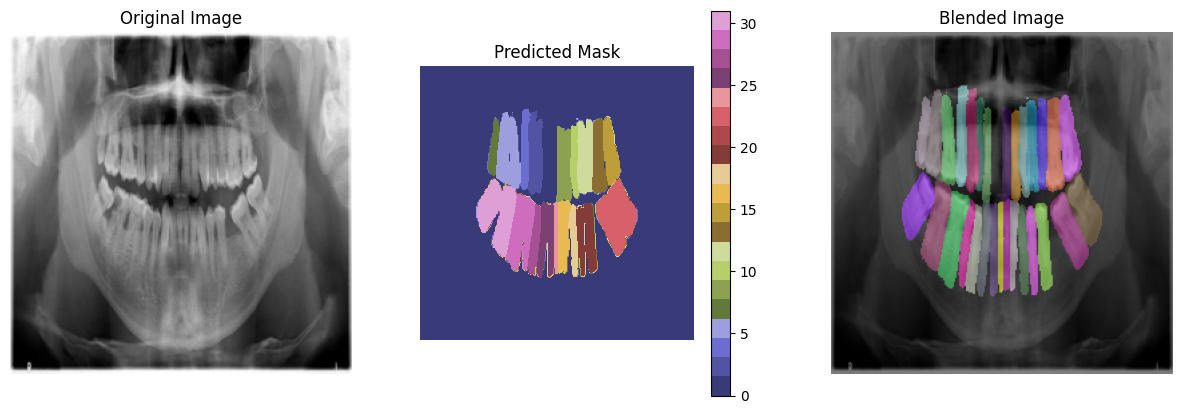

In [ ]:

# Example usage:


model_path = "drive/MyDrive/training_data/quadrant_enumeration/explore_unet.pth"
image_path = "drive/MyDrive/training_data/quadrant_enumeration/xrays_2048_1024/train_0.png"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = UNet(in_channels=1, out_channels=33)  # Adjust num_classes as needed
model.load_state_dict(torch.load(model_path))
model.to(device)

evaluate_and_visualize(model, image_path, device)



In [ ]:
def load_unet_model(model_path, device):
    model = UNet(in_channels=1, out_channels=33)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "drive/MyDrive/training_data/quadrant_enumeration/explore_unet.pth"
model = load_unet_model(model_path, device)

<ipython-input-22-3e41170955a0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [10]:
def calculate_dice_scores(model, val_loader, device):
    model = model.to(device)
    model.eval()

    # Initialize dice scores for teeth only (0-31)
    class_dice_scores = {i: [] for i in range(32)}  # 0-31 for teeth

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            pred_masks = torch.argmax(outputs, dim=1)

            # Calculate dice for each image in batch
            for pred, target in zip(pred_masks, masks):
                # Calculate dice for each tooth class (0-31)
                for tooth_idx in range(32):
                    pred_tooth = (pred == tooth_idx).float()
                    target_tooth = (target == tooth_idx).float()

                    intersection = (pred_tooth * target_tooth).sum()
                    union = pred_tooth.sum() + target_tooth.sum()

                    if union > 0:
                        dice = (2. * intersection) / (union + 1e-6)
                        class_dice_scores[tooth_idx].append(dice.item())

    # Calculate mean dice for each tooth
    mean_class_dice = {}
    for tooth_idx in range(32):
        if class_dice_scores[tooth_idx]:
            mean_class_dice[tooth_idx] = np.mean(class_dice_scores[tooth_idx])
        else:
            mean_class_dice[tooth_idx] = 0.0

    # Calculate overall mean dice across all teeth
    overall_mean_dice = np.mean(list(mean_class_dice.values()))

    return overall_mean_dice, mean_class_dice



In [ ]:
# Calculate scores
overall_dice, class_dice = calculate_dice_scores(model, val_loader, device)

# Print results
print(f"Overall Mean Dice Score: {overall_dice:.4f}")
print("\nPer-Tooth Dice Scores:")
for tooth_idx, dice_score in class_dice.items():
    print(f"Tooth {tooth_idx}: {dice_score:.4f}")

# Calculate scores
overall_dice, class_dice = calculate_dice_scores(model, val_loader, device)

# Print results
print(f"Overall Mean Dice Score (excluding background): {overall_dice:.4f}")
print("\nPer-Class Dice Scores:")
for class_idx, dice_score in class_dice.items():
    if class_idx == 32:
        print(f"Background: {dice_score:.4f}")
    else:
        print(f"Tooth {class_idx-1}: {dice_score:.4f}")

In [ ]:
def check_class_distribution(model, val_loader, device):
    model.eval()
    class_counts = {i: 0 for i in range(33)}  # 0-31 for teeth, 32 for background
    total_pixels = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            outputs = model(images)
            pred_masks = torch.argmax(outputs, dim=1)

            # Count occurrences of each class
            for i in range(33):
                class_counts[i] += (pred_masks == i).sum().item()
            total_pixels += pred_masks.numel()

    # Print distribution
    print("\nClass Distribution in Predictions:")
    for class_idx, count in class_counts.items():
        percentage = (count / total_pixels) * 100
        if class_idx == 32:
            print(f"Background (32): {percentage:.2f}%")
        else:
            print(f"Tooth {class_idx}: {percentage:.2f}%")

# Check distribution
check_class_distribution(model, val_loader, device)


Class Distribution in Predictions:
Tooth 0: 82.15%
Tooth 1: 0.48%
Tooth 2: 0.53%
Tooth 3: 0.53%
Tooth 4: 0.49%
Tooth 5: 0.70%
Tooth 6: 0.72%
Tooth 7: 0.38%
Tooth 8: 0.68%
Tooth 9: 0.51%
Tooth 10: 0.53%
Tooth 11: 0.53%
Tooth 12: 0.56%
Tooth 13: 0.67%
Tooth 14: 0.65%
Tooth 15: 0.42%
Tooth 16: 0.36%
Tooth 17: 0.42%
Tooth 18: 0.56%
Tooth 19: 0.51%
Tooth 20: 0.56%
Tooth 21: 0.76%
Tooth 22: 0.89%
Tooth 23: 0.56%
Tooth 24: 0.38%
Tooth 25: 0.44%
Tooth 26: 0.56%
Tooth 27: 0.54%
Tooth 28: 0.58%
Tooth 29: 0.78%
Tooth 30: 0.95%
Tooth 31: 0.59%
Background (32): 0.00%


In [ ]:
def visualize_prediction(model, image_path, device):
    # Load and prepare image
    image = Image.open(image_path).convert('L')
    original_size = image.size

    # Transform image
    transformed_image = transform(image, None)[0].unsqueeze(0).to(device)

    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(transformed_image)
        pred_mask = torch.argmax(output, dim=1)[0].cpu().numpy()

    # Create visualization
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Prediction overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')

    # Create color overlay for each class
    colors = plt.cm.rainbow(np.linspace(0, 1, 32))  # 32 colors for teeth
    for i in range(1, 33):  # Skip background (0)
        mask = pred_mask == i
        if mask.any():
            color_mask = np.zeros((*mask.shape, 4))
            color_mask[mask] = (*colors[i-1][:3], 0.3)  # Add alpha channel
            plt.imshow(color_mask)

    plt.title('Prediction Overlay')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage:
test_image_path = "drive/MyDrive/training_data/quadrant_enumeration/xrays_2048_1024/train_99.png"
visualize_prediction(model, test_image_path, device)

TypeError: Unexpected type <class 'NoneType'>

<ipython-input-12-16c86abdd60a>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


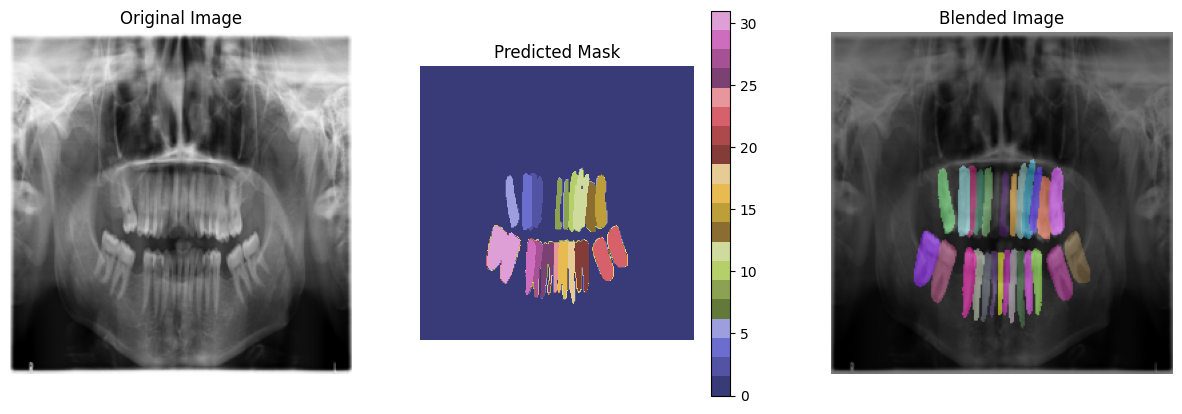

In [12]:

# Example usage:


model_path = "drive/MyDrive/training_data/quadrant_enumeration/explore_unet.pth"
image_path = "drive/MyDrive/training_data/quadrant_enumeration/xrays_2048_1024/train_99.png"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = UNet(in_channels=1, out_channels=33)  # Adjust num_classes as needed
model.load_state_dict(torch.load(model_path))
model.to(device)

evaluate_and_visualize(model, image_path, device)



In [15]:
TOOTH_TYPE_MAPPING = {
    # Quadrant 1 (Upper Right)
    0: 'incisor',  # Central incisor
    1: 'incisor',  # Lateral incisor
    2: 'canine',   # Canine
    3: 'premolar', # First premolar
    4: 'premolar', # Second premolar
    5: 'molar',    # First molar
    6: 'molar',    # Second molar
    7: 'molar',    # Third molar

    # Quadrant 2 (Upper Left)
    8: 'incisor',  # Central incisor
    9: 'incisor',  # Lateral incisor
    10: 'canine',  # Canine
    11: 'premolar', # First premolar
    12: 'premolar', # Second premolar
    13: 'molar',    # First molar
    14: 'molar',    # Second molar
    15: 'molar',    # Third molar

    # Quadrant 3 (Lower Left)
    16: 'incisor',  # Central incisor
    17: 'incisor',  # Lateral incisor
    18: 'canine',   # Canine
    19: 'premolar', # First premolar
    20: 'premolar', # Second premolar
    21: 'molar',    # First molar
    22: 'molar',    # Second molar
    23: 'molar',    # Third molar

    # Quadrant 4 (Lower Right)
    24: 'incisor',  # Central incisor
    25: 'incisor',  # Lateral incisor
    26: 'canine',   # Canine
    27: 'premolar', # First premolar
    28: 'premolar', # Second premolar
    29: 'molar',    # First molar
    30: 'molar',    # Second molar
    31: 'molar',    # Third molar
}


def calculate_dice_scores(model, val_loader, device):
    model = model.to(device)
    model.eval()

    # Initialize dice scores for teeth only (0-31)
    class_dice_scores = {i: [] for i in range(32)}  # 0-31 for teeth

    # Initialize dice scores by tooth type
    type_dice_scores = {
        'incisor': [],
        'canine': [],
        'premolar': [],
        'molar': []
    }

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            pred_masks = torch.argmax(outputs, dim=1)

            # Calculate dice for each image in batch
            for pred, target in zip(pred_masks, masks):
                # Calculate dice for each tooth class (0-31)
                for tooth_idx in range(32):
                    pred_tooth = (pred == tooth_idx).float()
                    target_tooth = (target == tooth_idx).float()

                    intersection = (pred_tooth * target_tooth).sum()
                    union = pred_tooth.sum() + target_tooth.sum()

                    if union > 0:
                        dice = (2. * intersection) / (union + 1e-6)
                        class_dice_scores[tooth_idx].append(dice.item())

    # Calculate mean dice for each tooth
    mean_class_dice = {}
    for tooth_idx in range(32):
        if class_dice_scores[tooth_idx]:
            mean_class_dice[tooth_idx] = np.mean(class_dice_scores[tooth_idx])
        else:
            mean_class_dice[tooth_idx] = 0.0

        # Add to tooth type aggregation
        tooth_type = TOOTH_TYPE_MAPPING.get(tooth_idx)
        if tooth_type:
            type_dice_scores[tooth_type].append(mean_class_dice[tooth_idx])

    # Calculate mean dice for each tooth type
    mean_type_dice = {
        tooth_type: np.mean(scores) if scores else 0.0
        for tooth_type, scores in type_dice_scores.items()
    }

    # Calculate overall mean dice across all teeth
    overall_mean_dice = np.mean(list(mean_class_dice.values()))

    # Print results
    print(f"\nOverall Mean Dice Score: {overall_mean_dice:.4f}")

    print("\nDice Scores by Tooth Type:")
    for tooth_type, score in mean_type_dice.items():
        print(f"{tooth_type.capitalize()}: {score:.4f}")

    print("\nDetailed Dice Scores by Class:")
    for tooth_idx in range(32):
        tooth_type = TOOTH_TYPE_MAPPING.get(tooth_idx, 'unknown')
        score = mean_class_dice[tooth_idx]
        print(f"Tooth {tooth_idx} ({tooth_type}): {score:.4f}")

    return overall_mean_dice, mean_class_dice, mean_type_dice

In [16]:
# Calculate scores
overall_dice, class_dice = calculate_dice_scores(model, val_loader, device)

# Print results
print(f"Overall Mean Dice Score: {overall_dice:.4f}")
print("\nPer-Tooth Dice Scores:")
for tooth_idx, dice_score in class_dice.items():
    print(f"Tooth {tooth_idx}: {dice_score:.4f}")

# Calculate scores
overall_dice, class_dice = calculate_dice_scores(model, val_loader, device)

# Print results
print(f"Overall Mean Dice Score (excluding background): {overall_dice:.4f}")
print("\nPer-Class Dice Scores:")
for class_idx, dice_score in class_dice.items():
    if class_idx == 32:
        print(f"Background: {dice_score:.4f}")
    else:
        print(f"Tooth {class_idx-1}: {dice_score:.4f}")


Overall Mean Dice Score: 0.8504

Dice Scores by Tooth Type:
Incisor: 0.7789
Canine: 0.8828
Premolar: 0.8579
Molar: 0.8821

Detailed Dice Scores by Class:
Tooth 0 (incisor): 0.0150
Tooth 1 (incisor): 0.8813
Tooth 2 (canine): 0.8557
Tooth 3 (premolar): 0.8498
Tooth 4 (premolar): 0.8491
Tooth 5 (molar): 0.9106
Tooth 6 (molar): 0.8971
Tooth 7 (molar): 0.8767
Tooth 8 (incisor): 0.9095
Tooth 9 (incisor): 0.8666
Tooth 10 (canine): 0.8690
Tooth 11 (premolar): 0.8324
Tooth 12 (premolar): 0.8437
Tooth 13 (molar): 0.9075
Tooth 14 (molar): 0.8980
Tooth 15 (molar): 0.7937
Tooth 16 (incisor): 0.8770
Tooth 17 (incisor): 0.8916
Tooth 18 (canine): 0.9059
Tooth 19 (premolar): 0.8963
Tooth 20 (premolar): 0.8706
Tooth 21 (molar): 0.8978
Tooth 22 (molar): 0.9017
Tooth 23 (molar): 0.8492
Tooth 24 (incisor): 0.8886
Tooth 25 (incisor): 0.9019
Tooth 26 (canine): 0.9005
Tooth 27 (premolar): 0.8700
Tooth 28 (premolar): 0.8510
Tooth 29 (molar): 0.8551
Tooth 30 (molar): 0.9157
Tooth 31 (molar): 0.8829


ValueError: too many values to unpack (expected 2)

In [36]:
def generate_coco_predictions(unet_model, val_loader, device, output_file="predictions.json"):
    """
    Generate COCO predictions from UNet segmentation masks.

    Args:
        unet_model: The trained UNet model.
        val_loader: DataLoader for the validation set.
        device: Device to run inference on (e.g., 'cuda' or 'cpu').
        output_file: Path to save the predictions JSON file.
    """
    unet_model.to(device)
    unet_model.eval()
    predictions = []

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(val_loader):
            # Move images to the target device
            images = images.to(device)
            batch_size, _, height, width = images.shape

            # Run inference
            outputs = unet_model(images)  # Shape: (batch_size, num_classes, height, width)
            predicted_masks = torch.argmax(outputs, dim=1).cpu().numpy()  # Class-wise masks

            # Get the correct image IDs for the batch
            batch_image_ids = [
                val_loader.dataset.dataset.image_ids[val_loader.dataset.indices[idx]]
                for idx in range(batch_idx * batch_size, batch_idx * batch_size + batch_size)
            ]

            for img_idx, image_id in enumerate(batch_image_ids):
                mask = predicted_masks[img_idx]

                for class_id in range(1, 31):  # Exclude background class (0)
                    binary_mask = (mask == class_id).astype(np.uint8)

                    # Skip empty masks
                    if binary_mask.sum() == 0:
                        continue

                    # Infer bounding box from binary mask
                    ys, xs = np.where(binary_mask)
                    x_min, x_max = xs.min(), xs.max()
                    y_min, y_max = ys.min(), ys.max()
                    bbox = [float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)]

                    # Encode the binary mask into RLE (Run-Length Encoding)
                    rle = coco_mask.encode(np.asfortranarray(binary_mask))
                    rle["counts"] = rle["counts"].decode("utf-8")  # Make JSON serializable

                    # Add the prediction to the results
                    predictions.append({
                        "image_id": int(image_id),
                        "category_id": int(class_id),
                        "bbox": bbox,
                        "score": 1.0,  # UNet does not produce confidence scores
                        "segmentation": rle
                    })

    # Save predictions to a JSON file
    with open(output_file, "w") as f:
        json.dump(predictions, f)

    print(f"Predictions saved to {output_file}")


In [39]:
# Load trained UNet model
unet_model = UNet(in_channels=1, out_channels=33)  # Adjust num_classes as needed
unet_model.load_state_dict(torch.load(model_path))
unet_model.to(device)
unet_model.eval()

predictions_file = os.path.join(base_dir, "unet_predictions.json")

# Generate predictions
generate_coco_predictions(unet_model, val_loader, device="cuda", output_file=predictions_file)


<ipython-input-39-87146e6dd849>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_model.load_state_dict(torch.load(model_path))


Predictions saved to drive/MyDrive/training_data/quadrant_enumeration/unet_predictions.json


In [25]:
import json

def filter_and_resize_coco_json(gt_json_path, val_image_ids, output_path, target_size=(256, 256)):
    """
    Filters a COCO ground truth JSON file to include only annotations for the validation set
    and resizes bounding boxes to the target size.

    Args:
        gt_json_path (str): Path to the ground truth COCO JSON file.
        val_image_ids (list): List of image IDs in the validation set.
        output_path (str): Path to save the filtered JSON file.
        target_size (tuple): Target image size (width, height) for resizing.
    """
    with open(gt_json_path, 'r') as f:
        coco_data = json.load(f)

    target_width, target_height = target_size

    # Filter images
    filtered_images = [
        {**img, "width": target_width, "height": target_height}
        for img in coco_data['images'] if img['id'] in val_image_ids
    ]

    # Filter annotations and resize bounding boxes
    filtered_annotations = []
    for ann in coco_data['annotations']:
        if ann['image_id'] in val_image_ids:
            original_width = next(img['width'] for img in coco_data['images'] if img['id'] == ann['image_id'])
            original_height = next(img['height'] for img in coco_data['images'] if img['id'] == ann['image_id'])

            # Scale the bounding box to the target size
            x, y, width, height = ann['bbox']
            scale_x = target_width / original_width
            scale_y = target_height / original_height

            resized_bbox = [
                x * scale_x,
                y * scale_y,
                width * scale_x,
                height * scale_y
            ]

            # Update the annotation with the resized bounding box
            filtered_annotations.append({
                **ann,
                "bbox": [round(coord, 2) for coord in resized_bbox]  # Keep bounding box precision
            })

    # Update the JSON structure
    filtered_coco_data = {
        'images': filtered_images,
        'annotations': filtered_annotations,
        'categories': coco_data['categories']  # Keep all categories
    }

    # Save the filtered and resized JSON
    with open(output_path, 'w') as f:
        json.dump(filtered_coco_data, f)

    print(f"Filtered and resized ground truth saved to {output_path}")

# Example usage:
input_file = os.path.join(base_dir, "coco_quadrant_enumeration_2048_1024.json")
actuals_file = os.path.join(base_dir, "unet_actuals.json")

# Extract the image IDs for the validation dataset
val_image_ids = [dataset.image_ids[idx] for idx in val_dataset.indices]

filter_and_resize_coco_json(input_file, val_image_ids, actuals_file, target_size=(256, 256))


Filtered and resized ground truth saved to drive/MyDrive/training_data/quadrant_enumeration/unet_actuals.json


In [41]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Load ground truth annotations and predictions
coco_gt = COCO(actuals_file)
coco_pred = coco_gt.loadRes(predictions_file)

# Initialize COCOeval for bounding boxes
bbox_eval = COCOeval(coco_gt, coco_pred, iouType='bbox')
bbox_eval.evaluate()
bbox_eval.accumulate()
bbox_eval.summarize()

# Initialize COCOeval for masks
mask_eval = COCOeval(coco_gt, coco_pred, iouType='segm')
mask_eval.evaluate()
mask_eval.accumulate()
mask_eval.summarize()


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.12s).
Accumulating evaluation results...
DONE (t=0.31s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.411
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.379
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.529
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.528
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [30]:
def visualize_bboxes(model, image_name, image_dir, predictions, actuals, device):
    """
    Visualize the raw image, predicted bounding boxes, and actual bounding boxes.

    Args:
        model (torch.nn.Module): Trained UNet model.
        image_name (str): Name of the input image.
        image_dir (str): Directory containing the raw images.
        predictions (list): COCO-formatted predictions for the image.
        actuals (dict): COCO-formatted actual annotations for the image.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        None. Displays the visualizations.
    """
    # Load and preprocess the image
    image_path = f"{image_dir}/{image_name}"
    image = Image.open(image_path).convert("L")  # Grayscale
    image_resized = TF.resize(image, (256, 256))  # Resize to 256x256
    image_tensor = TF.to_tensor(image_resized).unsqueeze(0).to(device)

    # Run the model for predictions (optional if masks are precomputed)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        predicted_mask = torch.argmax(output.squeeze(0), dim=0).cpu().numpy()  # Shape: (H, W)

    # Convert image to RGB for visualization
    image_rgb = np.array(image_resized.convert("RGB"))

    # Create an image for predicted bounding boxes
    pred_image = image_resized.convert("RGB")
    draw_pred = ImageDraw.Draw(pred_image)

    for img in actuals["images"]:
        if img["file_name"] == image_name:
            image_id = img["id"]
            break

    # Draw predicted bounding boxes
    for pred in predictions:
        if pred["image_id"] == image_id:
            x, y, width, height = pred["bbox"]
            draw_pred.rectangle([x, y, x + width, y + height], outline="red", width=2)

    # Create an image for actual bounding boxes
    actual_image = image_resized.convert("RGB")
    draw_actual = ImageDraw.Draw(actual_image)

    # Draw actual bounding boxes
    for actual in actuals["annotations"]:
        if actual["image_id"] == image_id:
            x, y, width, height = actual["bbox"]
            draw_actual.rectangle([x, y, x + width, y + height], outline="blue", width=2)

    # Display the images
    plt.figure(figsize=(15, 5))

    # Original resized image
    plt.subplot(1, 3, 1)
    plt.title("Raw Image (Resized)")
    plt.imshow(image_rgb)
    plt.axis("off")

    # Predicted bounding boxes
    plt.subplot(1, 3, 2)
    plt.title("Predicted Bounding Boxes")
    plt.imshow(pred_image)
    plt.axis("off")

    # Actual bounding boxes
    plt.subplot(1, 3, 3)
    plt.title("Actual Bounding Boxes")
    plt.imshow(actual_image)
    plt.axis("off")

    plt.show()


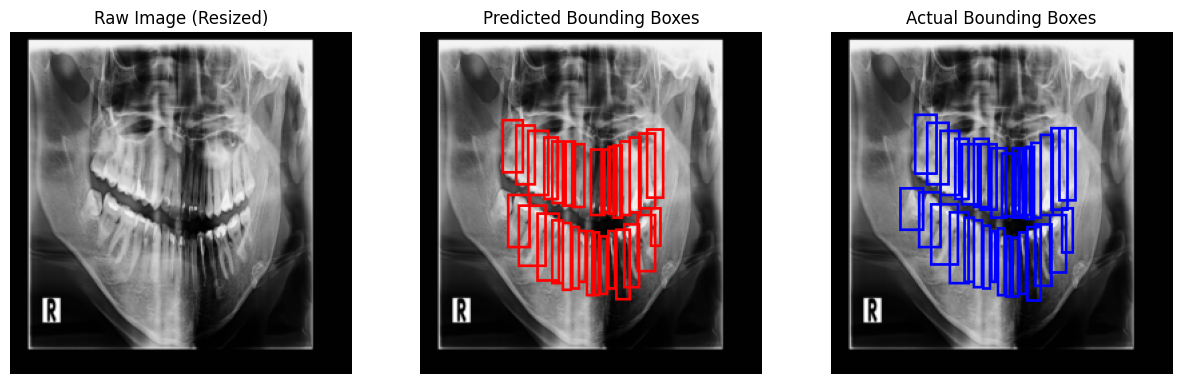

In [40]:
# Define inputs
image_name = "train_553.png"
image_dir = os.path.join(base_dir, "xrays_2048_1024")
# predictions_file = "unet_predictions.json"
# actuals_file = "unet_actuals.json"

# Load predictions and actuals
with open(predictions_file, "r") as f:
    predictions = json.load(f)

with open(actuals_file, "r") as f:
    actuals = json.load(f)

# Visualize bounding boxes
visualize_bboxes(
    model=unet_model,
    image_name=image_name,
    image_dir=image_dir,
    predictions=predictions,
    actuals=actuals,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
)


In [35]:
import json

def analyze_predictions(predictions_file):
    """
    Analyze the predictions.json file to count the total number of objects
    and unique image IDs.

    Args:
        predictions_file (str): Path to the predictions.json file.

    Returns:
        None. Prints the analysis results.
    """
    with open(predictions_file, 'r') as f:
        predictions = json.load(f)

    # Count total objects
    total_objects = len(predictions)

    # Extract unique image IDs
    unique_image_ids = set(pred["image_id"] for pred in predictions)

    print(f"Total Number of Objects: {total_objects}")
    print(f"Total Unique Image IDs: {len(unique_image_ids)}")

# Example usage
# predictions_file = "path/to/unet_predictions.json"
analyze_predictions(predictions_file)


Total Number of Objects: 3523
Total Unique Image IDs: 4
